#### https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

In [163]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [205]:
pd.set_option('display.max_columns', 71)

### read data file
The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe (1/0) a term deposit (variable y).

This dataset provides the customer information. It includes 41188 records and 21 fields.

In [165]:
# https://raw.githubusercontent.com/madmashup/targeted-marketing-predictive-engine/master/banking.csv
data = pd.read_csv('Data/bank/banking.csv', header = 0)
print(data.shape)
print(data.columns)

(41188, 21)
Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'y'],
      dtype='object')


In [166]:
pd.set_option('display.max_columns', 21)
data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,210,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,138,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,339,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,185,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,137,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,59,retired,married,high.school,unknown,no,yes,telephone,jun,thu,222,1,999,0,nonexistent,1.4,94.465,-41.8,4.866,5228.1,0
41184,31,housemaid,married,basic.4y,unknown,no,no,telephone,may,thu,196,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,0
41185,42,admin.,single,university.degree,unknown,yes,yes,telephone,may,wed,62,3,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
41186,48,technician,married,professional.course,no,no,yes,telephone,oct,tue,200,2,999,0,nonexistent,-3.4,92.431,-26.9,0.742,5017.5,0


### Input variables
1 - age (numeric)

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')

8 - contact: contact communication type (categorical: 'cellular','telephone')

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

16 - emp.var.rate: employment variation rate - (numeric)

17 - cons.price.idx: consumer price index - (numeric)

18 - cons.conf.idx: consumer confidence index - (numeric)

19 - euribor3m: euribor 3 month rate - (numeric)

20 - nr.employed: number of employees - (numeric)

Predict variable (desired target):
y - has the client subscribed a term deposit? (binary: '1','0')

### Data exploration

In [167]:
df_corr = data.corr()
filt = (df_corr >= .5) | (df_corr <= -0.5)
df_corr[filt]

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
age,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
campaign,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pdays,NaN,NaN,NaN,1.000000,-0.587514,NaN,NaN,NaN,NaN,NaN,NaN
previous,NaN,NaN,NaN,-0.587514,1.000000,NaN,NaN,NaN,NaN,-0.501333,NaN
emp_var_rate,NaN,NaN,NaN,NaN,NaN,1.000000,0.775334,NaN,0.972245,0.906970,NaN
cons_price_idx,NaN,NaN,NaN,NaN,NaN,0.775334,1.000000,NaN,0.688230,0.522034,NaN
cons_conf_idx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
euribor3m,NaN,NaN,NaN,NaN,NaN,0.972245,0.688230,NaN,1.000000,0.945154,NaN
nr_employed,NaN,NaN,NaN,NaN,-0.501333,0.906970,0.522034,NaN,0.945154,1.000000,NaN


In [168]:
# class imbalance
print(data['y'].value_counts())
print(data['y'].value_counts(normalize=True))

0    36548
1     4640
Name: y, dtype: int64
0    0.887346
1    0.112654
Name: y, dtype: float64


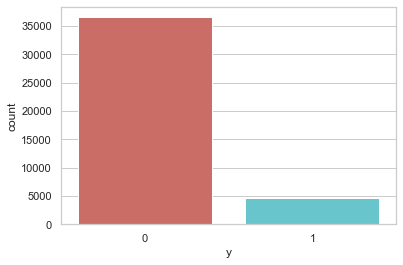

In [169]:
sns.countplot(x='y', data=data, palette='hls')
plt.show()
# Our classes are imbalanced, and the ratio of no-subscription to subscription instances is 89:11.

In [170]:
data.groupby('y').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
y,,,,,,,,,,
0,39.911185,220.844807,2.633085,984.113878,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.166600
1,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991


In [171]:
data.groupby('y').median()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
y,,,,,,,,,,
0,38.0,163.5,2.0,999.0,0.0,1.1,93.918,-41.8,4.857,5195.8
1,37.0,449.0,2.0,999.0,0.0,-1.8,93.200,-40.4,1.266,5099.1


In [172]:
data.groupby('job').mean()
# The average age of customers who bought the term deposit is higher than that of the customers who didn’t.
# The pdays (days since the customer was last contacted) is understandably lower for the customers who bought it. The lower the pdays, the better the memory of the last call and hence the better chances of a sale.
# Surprisingly, campaigns (number of contacts or calls made during the current campaign) are lower for customers who bought the term deposit.

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
job,,,,,,,,,,,
admin.,38.187296,254.312128,2.623489,954.319229,0.189023,0.015563,93.534054,-40.245433,3.550274,5164.125350,0.129726
blue-collar,39.555760,264.542360,2.558461,985.160363,0.122542,0.248995,93.656656,-41.375816,3.771996,5175.615150,0.068943
entrepreneur,41.723214,263.267857,2.535714,981.267170,0.138736,0.158723,93.605372,-41.283654,3.791120,5176.313530,0.085165
housemaid,45.500000,250.454717,2.639623,960.579245,0.137736,0.433396,93.676576,-39.495283,4.009645,5179.529623,0.100000
management,42.362859,257.058140,2.476060,962.647059,0.185021,-0.012688,93.522755,-40.489466,3.611316,5166.650513,0.112175
retired,62.027326,273.712209,2.476744,897.936047,0.327326,-0.698314,93.430786,-38.573081,2.770066,5122.262151,0.252326
self-employed,39.949331,264.142153,2.660802,976.621393,0.143561,0.094159,93.559982,-40.488107,3.689376,5170.674384,0.104856
services,37.926430,258.398085,2.587805,979.974049,0.154951,0.175359,93.634659,-41.290048,3.699187,5171.600126,0.081381
student,25.894857,283.683429,2.104000,840.217143,0.524571,-1.408000,93.331613,-40.187543,1.884224,5085.939086,0.314286


In [173]:
df_ct = pd.crosstab(data['job'],data['y'])
df_ct['y_0_per'] = df_ct[0]/(df_ct[0]+df_ct[1])
df_ct['y_1_per'] = df_ct[1]/(df_ct[0]+df_ct[1])
df_ct

y,0,1,y_0_per,y_1_per
job,,,,
admin.,9070,1352,0.870274,0.129726
blue-collar,8616,638,0.931057,0.068943
entrepreneur,1332,124,0.914835,0.085165
housemaid,954,106,0.900000,0.100000
management,2596,328,0.887825,0.112175
retired,1286,434,0.747674,0.252326
self-employed,1272,149,0.895144,0.104856
services,3646,323,0.918619,0.081381
student,600,275,0.685714,0.314286


Text(0, 0.5, 'Frequency of Purchase')

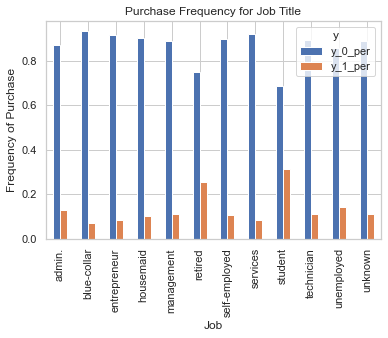

In [174]:
df_ct[['y_0_per', 'y_1_per']].plot(kind='bar')
plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')
# The frequency of purchase of the deposit depends a great deal on the job title. Thus, the job title can be a good predictor of the outcome variable.

Text(0, 0.5, 'Proportion of Customers')

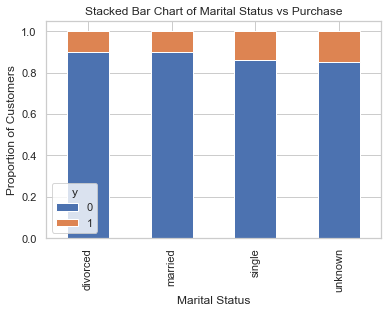

In [175]:
table=pd.crosstab(data.marital,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Marital Status vs Purchase')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')
# The marital status does not seem a strong predictor for the outcome variable.

Text(0, 0.5, 'Proportion of Customers')

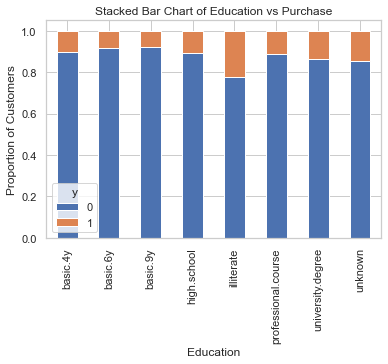

In [176]:
table=pd.crosstab(data.education,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Education vs Purchase')
plt.xlabel('Education')
plt.ylabel('Proportion of Customers')
# Education seems a good predictor of the outcome variable.

Text(0, 0.5, 'Frequency of Purchase')

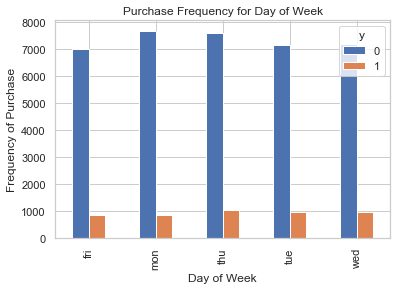

In [177]:
pd.crosstab(data.day_of_week,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Frequency of Purchase')
# Day of week may not be a good predictor of the outcome.

Text(0, 0.5, 'Frequency of Purchase')

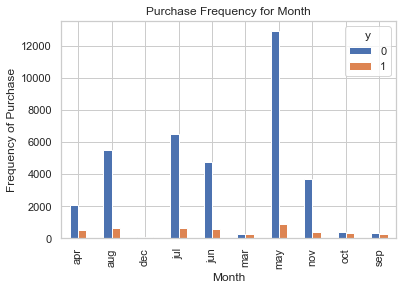

In [178]:
pd.crosstab(data.month,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Month')
plt.xlabel('Month')
plt.ylabel('Frequency of Purchase')
# Month might be a good predictor of the outcome variable.

Text(0, 0.5, 'Frequency')

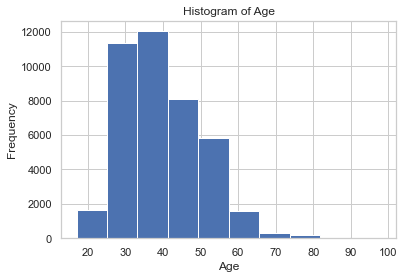

In [179]:
data.age.hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
# Most of the customers of the bank in this dataset are in the age range of 30–40.

Text(0, 0.5, 'Frequency of Purchase')

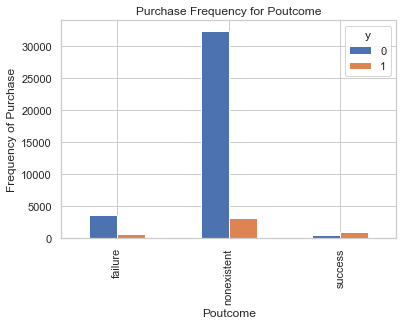

In [180]:
pd.crosstab(data.poutcome,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Poutcome')
plt.xlabel('Poutcome')
plt.ylabel('Frequency of Purchase')
# Poutcome seems to be a good predictor of the outcome variable.

Text(0, 0.5, 'Frequency of Purchase')

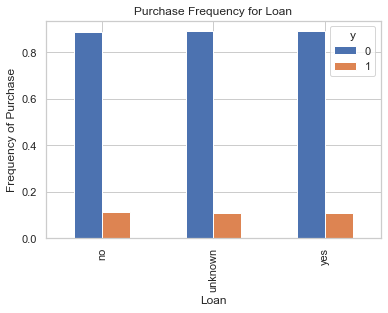

In [181]:
df_ct_loan = pd.crosstab(data['loan'],data['y'])
df_ct_loan.div(df_ct_loan.sum(axis = 1), axis = 0).plot(kind='bar')
plt.title('Purchase Frequency for Loan')
plt.xlabel('Loan')
plt.ylabel('Frequency of Purchase')

#### Creating a copy of the dataset before data manipulation

In [182]:
data1 = data.copy(deep=True)
data1

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,210,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,138,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,339,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,185,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,137,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,59,retired,married,high.school,unknown,no,yes,telephone,jun,thu,222,1,999,0,nonexistent,1.4,94.465,-41.8,4.866,5228.1,0
41184,31,housemaid,married,basic.4y,unknown,no,no,telephone,may,thu,196,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,0
41185,42,admin.,single,university.degree,unknown,yes,yes,telephone,may,wed,62,3,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
41186,48,technician,married,professional.course,no,no,yes,telephone,oct,tue,200,2,999,0,nonexistent,-3.4,92.431,-26.9,0.742,5017.5,0


### Data modification and cleaning

The education column of the dataset has many categories and we need to reduce the categories for a better modelling. The education column has the following categories:

In [183]:
data1['education'].unique()

array(['basic.4y', 'unknown', 'university.degree', 'high.school',
       'basic.9y', 'professional.course', 'basic.6y', 'illiterate'],
      dtype=object)

In [184]:
ed_grp = data1.groupby(['education'])
ed_grp['y'].value_counts(normalize = True)

education            y
basic.4y             0    0.897510
                     1    0.102490
basic.6y             0    0.917976
                     1    0.082024
basic.9y             0    0.921754
                     1    0.078246
high.school          0    0.891645
                     1    0.108355
illiterate           0    0.777778
                     1    0.222222
professional.course  0    0.886515
                     1    0.113485
university.degree    0    0.862755
                     1    0.137245
unknown              0    0.854997
                     1    0.145003
Name: y, dtype: float64

In [185]:
data1['education'].value_counts()

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64

In [186]:
data1['education'].replace({'basic.4y':'basic','basic.6y':'basic','basic.9y':'basic'}, inplace=True)

##### Create dummy variables

In [187]:
# saving the list of dummy columns names in a variable
cat_vars = data1.dtypes[data1.dtypes == 'object'].index.tolist()
# loop to add dummy columns for each column to the dataframe
for var in cat_vars:
    dummy_cols = pd.get_dummies(data1[var], prefix=var)
    data1 = data1.join(dummy_cols)
#saving the list of column names in a variable    
data_vars = data1.columns.values.tolist()
data_vars

['age',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed',
 'y',
 'job_admin.',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'marital_unknown',
 'education_basic',
 'education_high.school',
 'education_illiterate',
 'education_professional.course',
 'education_university.degree',
 'education_unknown',
 'default_no',
 'default_unknown',
 'default_yes',
 'housing_no',
 'housing_unknown',
 'housing_yes',
 'loan_no',
 'loan_unknown',
 'loan_yes',
 'contact_cellular',
 'contact_telephone',
 'month_apr',
 'month_aug',
 'month_dec',
 'month_jul',
 'month_jun',
 'month_mar',
 'month

In [188]:
to_keep = [i for i in data_vars if i not in cat_vars]
data_dummy = data1[to_keep]
print(len(data_dummy.columns.values))
print(len(data_vars))
print(len(cat_vars))

62
72
10


#### Over-sampling using SMOTE (Synthetic Minority Oversampling Technique)
1. Works by creating synthetic samples from the minor class (no-subscription) instead of creating copies.
2. Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.

In [189]:
y_dummy = data_dummy.loc[:, 'y']
X_dummy = data_dummy.loc[:, data_dummy.columns != 'y']

In [190]:
X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy = train_test_split(X_dummy, y_dummy, test_size=0.3, random_state=0)
columns = X_train_dummy.columns

In [191]:
os = SMOTE(random_state=0)
X_train_smote, y_train_smote = os.fit_sample(X_train_dummy, y_train_dummy)
type(y_train_smote)
y_train_smote = pd.DataFrame(data=y_train_smote, columns=['y'])

In [192]:
# we can Check the numbers of our data
print("length of oversampled data is ",len(X_train_smote))
print("Number of no subscription in oversampled data",len(y_train_smote[y_train_smote['y']==0]))
print("Number of subscription",len(y_train_smote[y_train_smote['y']==1]))
print("Proportion of no subscription data in oversampled data is ",len(y_train_smote[y_train_smote['y']==0])/len(X_train_smote))
print("Proportion of subscription data in oversampled data is ",len(y_train_smote[y_train_smote['y']==1])/len(X_train_smote))

length of oversampled data is  51134
Number of no subscription in oversampled data 25567
Number of subscription 25567
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [193]:
data_final_vars = data_dummy.columns.values.tolist()
y_smote_cols = ['y']
X_smote_cols = list(set(data_final_vars) - set(y_smote_cols))
# X_smote_cols = [i for i in data_final_vars if i not in y] -- another way to remove 'y' from the list

##### Feature Scaling

In [194]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train_smote.iloc[:, 0:10])
X_test_scaled = sc.transform(X_test_dummy.iloc[:, 0:10])

In [195]:
to_drop = X_train_smote.iloc[:,0:10].columns.values.tolist()
to_drop
X_train_smote.drop(columns=to_drop, axis=1, inplace=True)
to_keep = X_train_smote.columns.values.tolist()

In [196]:
X_train_scaled = pd.concat([X_train_smote, pd.DataFrame(X_train_scaled)], axis=1)
X_train_scaled.shape

(51134, 61)

In [197]:
X_train_scaled.columns = to_keep+to_drop

In [198]:
X_train_scaled

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
0,0,0,0,0,0,0,0,0,0,1,...,-0.791813,-0.353298,-0.519404,0.352165,1.280446,0.232307,-0.445119,-0.348304,0.629553,0.693475
1,1,0,0,0,0,0,0,0,0,0,...,0.342281,-0.237097,-0.519404,0.352165,-0.418509,0.929581,0.830237,0.722947,1.002550,0.638096
2,0,0,0,0,1,0,0,0,0,0,...,0.255043,-0.707569,-0.519404,0.352165,-0.418509,0.929581,0.830237,0.722947,1.002550,0.638096
3,0,1,0,0,0,0,0,0,0,0,...,-0.442861,-0.608374,-0.078609,0.352165,-0.418509,0.232307,-0.445119,-0.348304,0.629553,0.693475
4,1,0,0,0,0,0,0,0,0,0,...,-0.617337,-0.364635,-0.078609,0.352165,1.280446,-0.755499,-0.938235,-1.151743,-0.900053,-0.422193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51129,0,0,0,0,0,0,0,0,0,0,...,0.255043,-0.478002,-0.519404,0.352165,-0.418509,-1.685198,-1.763843,1.985493,-1.155564,-1.363646
51130,0,0,0,0,0,0,0,0,0,0,...,3.395611,-0.642384,-0.078609,0.352165,-0.418509,-0.755499,-1.015899,-1.874722,-0.771171,-0.422193
51131,0,0,0,0,0,0,0,0,0,0,...,-1.140765,-0.801097,-0.519404,-2.841258,1.280446,-0.921946,-0.458359,1.200259,-1.213888,-1.446998
51132,0,0,0,0,0,0,0,0,0,0,...,-0.355623,0.941917,0.802980,0.352165,-0.418509,1.103900,0.728631,-0.478200,1.058145,1.066134


In [223]:
X_test_scaled_df = pd.DataFrame(X_test_scaled)

In [229]:
X_test_scaled_df.set_index(X_test_dummy.index, inplace=True)

In [233]:
to_drop = X_test_dummy.iloc[:,0:10].columns.values.tolist()
print(to_drop)
X_test_dummy.drop(columns=to_drop, axis=1, inplace=True)
to_keep = X_test_dummy.columns.values.tolist()
print(to_keep)

['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']


C:\Users\Siddharth_Malani\Anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [239]:
X_test_scaled = pd.concat([X_test_dummy, X_test_scaled_df], axis=1)

In [241]:
X_test_scaled.columns = to_keep+to_drop

#### Recursive Feature Elimination

In [200]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [202]:
logreg = LogisticRegression(max_iter=300)
rfe = RFE(logreg, n_features_to_select=20)
rfe.fit(X_train_scaled, y_train_smote.values.ravel())
support = rfe.support_
ranking = rfe.ranking_

In [203]:
print(support)
print(ranking)

[False False False False False False False False False False False False
  True  True  True  True  True  True False  True  True  True False False
 False  True  True  True  True  True  True False False False False False
 False False False False False False False  True  True  True  True  True
 False False False False False False False False False False False False
 False]
[15  8  9 10 14 19 13 12 18 11 17 16  1  1  1  1  1  1 21  1  1  1  3  2
 40  1  1  1  1  1  1  5  4 26 33 27 29 28 36 23 25 31 32  1  1  1  1  1
  7  6 34 42 20 39 35 41 22 24 38 30 37]


In [211]:
df_variable_rfe = pd.DataFrame(np.concatenate((support.reshape(len(support),1), np.array(X_smote_cols).reshape(len(X_smote_cols),1)), 1))
cols = df_variable_rfe[df_variable_rfe[0] == 'True'][1].values.tolist()

In [214]:
X_train_RFE = X_train_scaled[cols]
y_train_RFE = y_train_smote['y']

In [219]:
# run if 20 features are selected usinr RFE
logit_model = sm.Logit(y_train_RFE, X_train_RFE)
result_20 = logit_model.fit()
print(result_20.summary2())

Optimization terminated successfully.
         Current function value: 0.370902
         Iterations 7
                           Results: Logit
Model:                Logit             Pseudo R-squared:  0.465     
Dependent Variable:   y                 AIC:               37971.3657
Date:                 2021-05-30 15:35  BIC:               38148.2098
No. Observations:     51134             Log-Likelihood:    -18966.   
Df Model:             19                LL-Null:           -35443.   
Df Residuals:         51114             LLR p-value:       0.0000    
Converged:            1.0000            Scale:             1.0000    
No. Iterations:       7.0000                                         
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
housing_yes          -0.3438   0.0256 -13.4275 0.0000 -0.3940 -0.2937
loan_yes        

##### run if 30 features are selected usinr RFE
import statsmodels.api as sm
logit_model = sm.Logit(y, X)
result_30 = logit_model.fit()
print(result_30.summary2())

In [222]:
final_var = result_20.pvalues[result_20.pvalues <= 0.05].index.values.tolist()
print(len(final_var))
print(final_var)

18
['housing_yes', 'loan_yes', 'month_sep', 'job_unemployed', 'job_blue-collar', 'month_aug', 'previous', 'day_of_week_mon', 'pdays', 'job_admin.', 'job_unknown', 'poutcome_failure', 'contact_cellular', 'cons_price_idx', 'age', 'marital_unknown', 'day_of_week_wed', 'duration']


In [243]:
X_train_final = X_train_RFE[final_var]
y_train_final = y_smote['y']

       housing_yes  loan_yes  month_sep  job_unemployed  job_blue-collar  \
0                0         0          0               0                0   
1                1         0          0               0                0   
2                1         0          0               0                0   
3                0         0          0               0                1   
4                1         1          0               0                0   
...            ...       ...        ...             ...              ...   
51129            1         0          1               0                0   
51130            0         0          0               0                0   
51131            1         0          0               0                0   
51132            1         0          0               0                0   
51133            0         0          0               0                0   

       month_aug  previous  day_of_week_mon     pdays  job_admin.  \
0              0  

In [248]:
X_test_final = X_test_scaled[final_var]

In [250]:
from sklearn.linear_model import LinearRegression
logReg = LogisticRegression()
logReg.fit(X_train_final, y_train_final)

LogisticRegression()

In [251]:
y_pred = logReg.predict(X_test_final)
print('Accuracy of logistic regression classifier on test set: {:.3f}'.format(logReg.score(X_test_final, y_test_dummy)))

Accuracy of logistic regression classifier on test set: 0.843


In [252]:
conf_matrix = confusion_matrix(y_test_dummy, y_pred)
print(conf_matrix)
# The result is telling us that we have 9533+889 correct predictions and 1448+487 incorrect predictions.

[[9533 1448]
 [ 487  889]]


In [254]:
print(classification_report(y_test_dummy, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.87      0.91     10981
           1       0.38      0.65      0.48      1376

    accuracy                           0.84     12357
   macro avg       0.67      0.76      0.69     12357
weighted avg       0.89      0.84      0.86     12357



In [262]:
# Precision is the ability of a classifier not to label an instance positive that is actually negative. TP/(TP + FP)
Precision = 9533/(9533+487)
# Recall is the ability of a classifier to find all positive instances. TP/(TP+FN)
Recall = 9533/(9533+1448)
# The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. 
# Generally speaking, F1 scores are lower than accuracy measures as they embed precision and recall into their computation. 
# As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy.
f1_score = 2*(Recall * Precision) / (Recall + Precision)
print('Precision: {}, Recall: {}, F1_Score: {}'.format(Precision, Recall, f1_score))

Precision: 0.9513972055888223, Recall: 0.8681358710499955, F1_Score: 0.9078615304033142


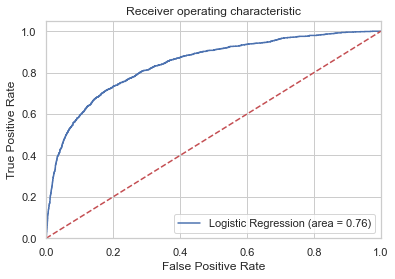

In [259]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test_dummy, y_pred)
fpr, tpr, thresholds = roc_curve(y_test_dummy, logReg.predict_proba(X_test_final)[:,1])
plt.figure()
plt.plot(fpr, tpr, label = 'Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [261]:
np.concatenate((fpr.reshape(len(fpr),1), tpr.reshape(len(tpr),1), thresholds.reshape(len(thresholds),1)), 1)

[[0.00000000e+00 0.00000000e+00 1.99999995e+00]
 [9.10663874e-05 0.00000000e+00 9.99999948e-01]
 [9.10663874e-05 1.45348837e-03 9.99999777e-01]
 ...
 [9.76231673e-01 9.99273256e-01 4.10022540e-03]
 [9.76231673e-01 1.00000000e+00 4.09326456e-03]
 [1.00000000e+00 1.00000000e+00 3.14927526e-04]]
